In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F

# Путь к директории с изображениями
data_dir = 'images'  # путь к папке с разархивированными изображениями

# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Создание датасета
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Деление на тренировочную и тестовую выборки
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [3]:
class PokemonNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PokemonNet(num_classes=len(full_dataset.classes)).to(device)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter()
best_acc = 0.0
best_weights = None
num_epochs = 20

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        best_weights = model.state_dict()

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/test', test_acc, epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Epoch 1/20 | Train Loss: 6.8196 | Train Acc: 0.15% | Test Loss: 6.8005 | Test Acc: 0.20%
Epoch 2/20 | Train Loss: 6.6899 | Train Acc: 0.65% | Test Loss: 6.8585 | Test Acc: 0.40%
Epoch 3/20 | Train Loss: 6.2482 | Train Acc: 2.65% | Test Loss: 6.8526 | Test Acc: 1.40%
Epoch 4/20 | Train Loss: 5.3453 | Train Acc: 10.09% | Test Loss: 6.9053 | Test Acc: 3.79%
Epoch 5/20 | Train Loss: 3.6930 | Train Acc: 29.72% | Test Loss: 7.4434 | Test Acc: 5.59%
Epoch 6/20 | Train Loss: 2.0094 | Train Acc: 60.34% | Test Loss: 8.1570 | Test Acc: 7.98%
Epoch 7/20 | Train Loss: 1.0951 | Train Acc: 76.12% | Test Loss: 9.3875 | Test Acc: 8.98%
Epoch 8/20 | Train Loss: 0.6647 | Train Acc: 85.46% | Test Loss: 10.4140 | Test Acc: 9.58%
Epoch 9/20 | Train Loss: 0.4221 | Train Acc: 90.81% | Test Loss: 11.2081 | Test Acc: 10.58%
Epoch 10/20 | Train Loss: 0.3906 | Train Acc: 91.01% | Test Loss: 10.5585 | Test Acc: 10.18%
Epoch 11/20 | Train Loss: 0.2489 | Train Acc: 94.16% | Test Loss: 11.6713 | Test Acc: 8.78%
Epoch

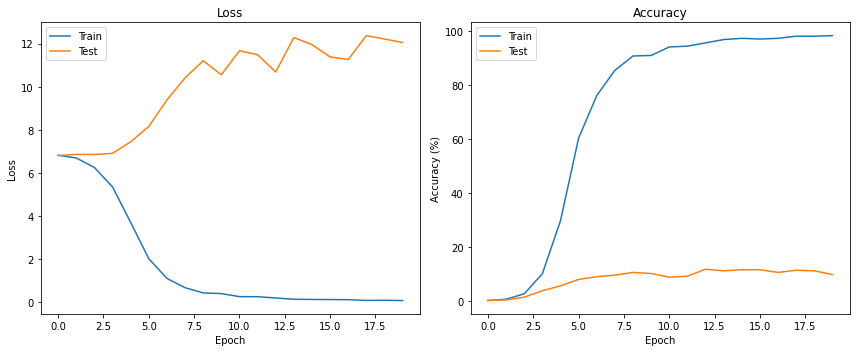

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
torch.save(best_weights, 'pokemon_best_model.pth')
model.load_state_dict(torch.load('pokemon_best_model.pth'))


<All keys matched successfully>

Визуализация предсказаний модели:


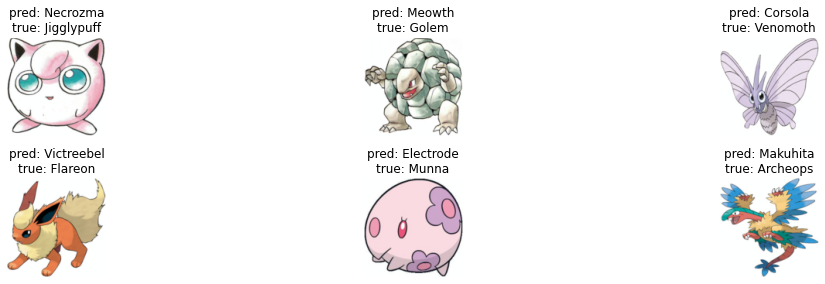

In [9]:
import numpy as np

def visualize_predictions(num_images=6):
    model.eval()
    shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    plt.tight_layout()
                    return

                img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                ax = plt.subplot(num_images // 2, 3, shown + 1)
                ax.imshow(img)
                ax.axis('off')
                pred_label = full_dataset.classes[preds[i]]
                true_label = full_dataset.classes[labels[i]]
                ax.set_title(f"pred: {pred_label}\ntrue: {true_label}")

                shown += 1

print("Визуализация предсказаний модели:")
visualize_predictions()


In [37]:
from PIL import Image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Загрузка сохранённой модели
loaded_model = PokemonNet(len(full_dataset.classes))
loaded_model.load_state_dict(torch.load('pokemon_best_model.pth'))
loaded_model.to(device)
loaded_model.eval()

# Предсказание на новом изображении
def predict_new_image(image_path):
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = loaded_model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_prob, top_class = torch.topk(probs, 3)

    print(f"\n Предсказания для: {os.path.basename(image_path)}")
    for prob, idx in zip(top_prob[0], top_class[0]):
        print(f"{full_dataset.classes[idx]}: {prob.item()*100:.2f}%")

    # Визуализация
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Исходное изображение")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    y_pos = np.arange(3)
    plt.barh(y_pos, [p.item() for p in top_prob[0]], align='center')
    plt.yticks(y_pos, [full_dataset.classes[i] for i in top_class[0]])
    plt.xlabel("Вероятность")
    plt.title("Топ-3 предсказания")
    
    plt.tight_layout()
    plt.show()


 Предсказания для: 2.jpg
Diancie: 28.70%
Ninetales: 11.16%
Milcery: 7.51%


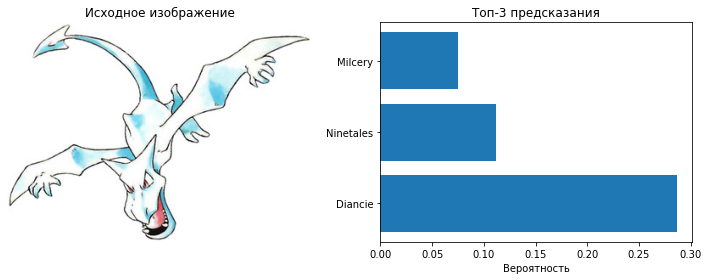

In [38]:
predict_new_image(test_dataset.dataset.imgs[20][0])

Проблема: модель переобучается, тренировочная точность достигает 98–99%, а на тестовой — 10–12%.

Причина: маленькое количество изображений в каждом классе (часто по 1–5), что делает задачу многоклассовой классификации нестабильной.

Решения:

Использовать агрессивные аугментации (перевороты, сдвиги, шумы).

Применить предобученные модели (например, ResNet18 или EfficientNet).

Провести тюнинг гиперпараметров: lr, batch_size, глубину сети.

Уменьшить количество классов или группировать похожие.

